In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import sys
import numpy as np
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import BatchNormalization
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.datasets import mnist
from random import randint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
class Discriminator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.CAPACITY = width*height*channels
        self.SHAPE = (width, height, channels)
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.Discriminator = self.model()
        self.Discriminator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER, metrics=['accuracy'] )
        self.summary()

    def model(self):
        model = Sequential()
        # 28,28,1 
        model.add(Flatten(input_shape=self.SHAPE))
        # 28*28*1 = (784,)
        model.add(Dense(self.CAPACITY, input_shape=self.SHAPE))
        # (28,28,1) -> (784)
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(int(self.CAPACITY/2)))
        # (784) -> (392)
        model.add(LeakyReLU(alpha=0.2))
        # (392) -> (1) : Sigmoid 0~1
        model.add(Dense(1, activation='sigmoid'))
        return model

    def summary(self):
        return self.Discriminator.summary()


In [ ]:
class Generator(object):
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100):
        self.W = width
        self.H = height
        self.C = channels
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)

        self.LATENT_SPACE_SIZE = latent_size
        self.latent_space = np.random.normal(0,1,(self.LATENT_SPACE_SIZE,))

        self.Generator = self.model()
        self.Generator.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self, block_starting_size=128,num_blocks=4):
        model = Sequential()
        
        block_size = block_starting_size 
        model.add(Dense(block_size, input_shape=(self.LATENT_SPACE_SIZE,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        for i in range(num_blocks-1):
            block_size = block_size * 2
            model.add(Dense(block_size))
            model.add(LeakyReLU(alpha=0.2))
            model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.W * self.H * self.C, activation='tanh'))
        model.add(Reshape((self.W, self.H, self.C)))
        
        return model

    def summary(self):
        return self.Generator.summary()


In [ ]:
  class GAN(object):
    # Generator 를 학습 시키기 위한 부분
    def __init__(self,discriminator,generator):
        self.OPTIMIZER = Adam(lr=0.0002, decay=8e-9)
        self.Generator = generator
        self.Discriminator = discriminator
        self.Discriminator.trainable = False
        
        self.gan_model = self.model()
        self.gan_model.compile(loss='binary_crossentropy', optimizer=self.OPTIMIZER)
        self.summary()

    def model(self):
        model = Sequential()
        model.add(self.Generator)
        model.add(self.Discriminator)
        return model

    def summary(self):
        return self.gan_model.summary()

In [ ]:
class Trainer:
    def __init__(self, width = 28, height= 28, channels = 1, latent_size=100, epochs =50000, batch=32, checkpoint=50,model_type=-1):
        self.W = width
        self.H = height
        self.C = channels
        self.EPOCHS = epochs
        self.BATCH = batch
        self.CHECKPOINT = checkpoint
        self.model_type=model_type

        self.LATENT_SPACE_SIZE = latent_size

        self.generator = Generator(height=self.H, width=self.W, channels=self.C, latent_size=self.LATENT_SPACE_SIZE)
        self.discriminator = Discriminator(height=self.H, width=self.W, channels=self.C)
        self.gan = GAN(generator=self.generator.Generator, discriminator=self.discriminator.Discriminator)

        self.load_MNIST()

    def load_MNIST(self,model_type=7):
        allowed_types = [-1,0,1,2,3,4,5,6,7,8,9]
        if self.model_type not in allowed_types:
            print('ERROR: Only Integer Values from -1 to 9 are allowed')

        (self.X_train, self.Y_train), (_, _) = mnist.load_data()
        if self.model_type!=-1:
            self.X_train = self.X_train[np.where(self.Y_train==int(self.model_type))[0]]
        
        # Rescale -1 to 1
        # Find Normalize Function from CV Class  
        # (0 ~ 255) -127.5 
        # (-127.5 ~ 127.5) / 127.5 
        # -1 ~ 1
        self.X_train = ( np.float32(self.X_train) - 127.5) / 127.5
        self.X_train = np.expand_dims(self.X_train, axis=3)
        return

    def train(self):
        for e in range(self.EPOCHS):
            count_real_images = int(self.BATCH/2)
            starting_index = randint(0, (len(self.X_train)-count_real_images))
            real_images_raw = self.X_train[ starting_index : (starting_index + count_real_images) ]
            x_real_images = real_images_raw.reshape( count_real_images, self.W, self.H, self.C )
            y_real_labels = np.ones([count_real_images,1])

            # Grab Generated Images for this training batch
            latent_space_samples = self.sample_latent_space(count_real_images)
            x_generated_images = self.generator.Generator.predict(latent_space_samples)
            y_generated_labels = np.zeros([self.BATCH-count_real_images,1])

            # Combine to train on the discriminator
            x_batch = np.concatenate( [x_real_images, x_generated_images] )
            y_batch = np.concatenate( [y_real_labels, y_generated_labels] )

            # Now, train the discriminator with this batch
            discriminator_loss = self.discriminator.Discriminator.train_on_batch(x_batch,y_batch)[0]
        
            # Generate Noise
            if e % 5 == 0:
              x_latent_space_samples = self.sample_latent_space(self.BATCH)
              y_generated_labels = np.ones([self.BATCH,1])
              generator_loss = self.gan.gan_model.train_on_batch(x_latent_space_samples,y_generated_labels)
                
            if e % self.CHECKPOINT == 0 :
              print ('Epoch: '+str(int(e))+', [Discriminator :: Loss: '+str(discriminator_loss)+'], [ Generator :: Loss: '+str(generator_loss)+']')
              self.plot_checkpoint(e)
                        
        return

    def sample_latent_space(self, instances):
        return np.random.normal(0, 1, (instances, self.LATENT_SPACE_SIZE))

    def plot_checkpoint(self,e):
        noise = self.sample_latent_space(16)
        images = self.generator.Generator.predict(noise)
        
        plt.figure(figsize=(4,4))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = (image *127.5) + 127.5
            image = np.reshape(image*255.0, [self.H,self.W])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        plt.show()
#         plt.close('all')
        return

In [ ]:
# Command Line Argument Method
HEIGHT  = 28
WIDTH   = 28
CHANNEL = 1
LATENT_SPACE_SIZE = 100
EPOCHS = 5000
BATCH = 32
CHECKPOINT = 100
MODEL_TYPE = 5

In [ ]:
trainer = Trainer(height=HEIGHT,\
                 width=WIDTH,\
                 channels=CHANNEL,\
                 latent_size=LATENT_SPACE_SIZE,\
                 epochs =EPOCHS,\
                 batch=BATCH,\
                 checkpoint=CHECKPOINT,
                 model_type=MODEL_TYPE)



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 512)              

/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0, [Discriminator :: Loss: 0.9803096], [ Generator :: Loss: 0.79706585]


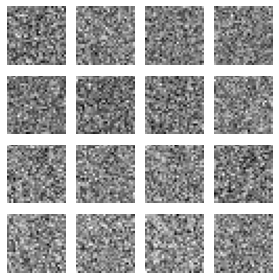

/tensorflow-1.15.2/python3.6/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 100, [Discriminator :: Loss: 0.00383136], [ Generator :: Loss: 5.956733]


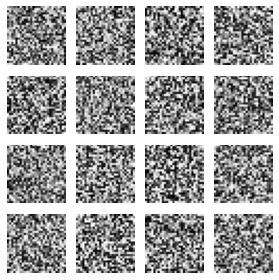

Epoch: 200, [Discriminator :: Loss: 0.00044748036], [ Generator :: Loss: 7.0888977]


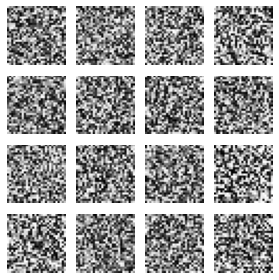

Epoch: 300, [Discriminator :: Loss: 0.0005767671], [ Generator :: Loss: 7.6569014]


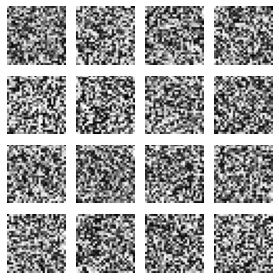

Epoch: 400, [Discriminator :: Loss: 0.00065774325], [ Generator :: Loss: 8.073702]


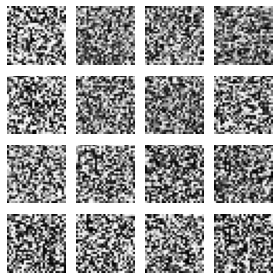

Epoch: 500, [Discriminator :: Loss: 0.00032188284], [ Generator :: Loss: 8.466199]


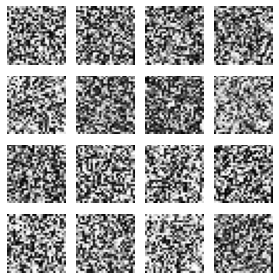

Epoch: 600, [Discriminator :: Loss: 0.0003422388], [ Generator :: Loss: 9.009937]


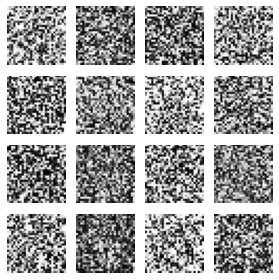

Epoch: 700, [Discriminator :: Loss: 0.00032240892], [ Generator :: Loss: 9.294714]


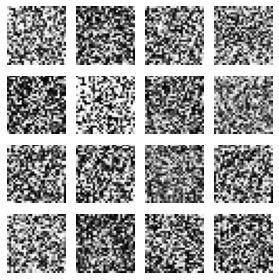

Epoch: 800, [Discriminator :: Loss: 0.00062144286], [ Generator :: Loss: 11.012364]


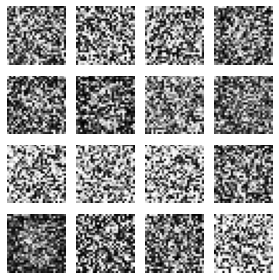

Epoch: 900, [Discriminator :: Loss: 0.011049799], [ Generator :: Loss: 16.843245]


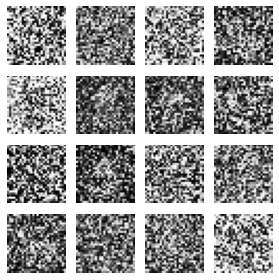

Epoch: 1000, [Discriminator :: Loss: 0.006011786], [ Generator :: Loss: 12.463219]


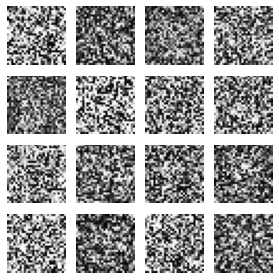

Epoch: 1100, [Discriminator :: Loss: 0.0011980387], [ Generator :: Loss: 10.192287]


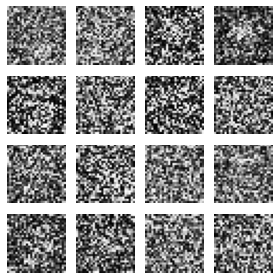

Epoch: 1200, [Discriminator :: Loss: 0.003633848], [ Generator :: Loss: 11.992238]


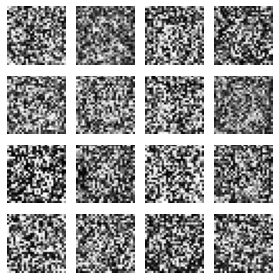

Epoch: 1300, [Discriminator :: Loss: 0.0005266284], [ Generator :: Loss: 14.663301]


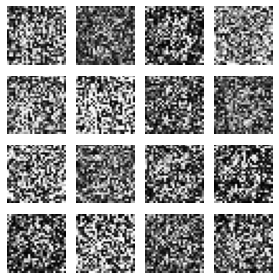

Epoch: 1400, [Discriminator :: Loss: 0.0030252142], [ Generator :: Loss: 14.686062]


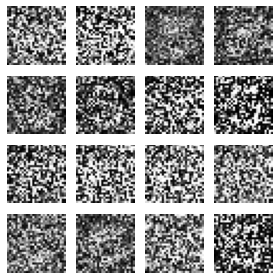

Epoch: 1500, [Discriminator :: Loss: 0.0013272867], [ Generator :: Loss: 13.289148]


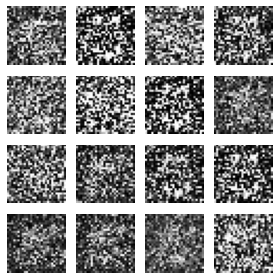

Epoch: 1600, [Discriminator :: Loss: 0.001048343], [ Generator :: Loss: 14.331114]


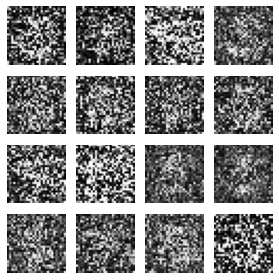

Epoch: 1700, [Discriminator :: Loss: 0.07417515], [ Generator :: Loss: 17.976791]


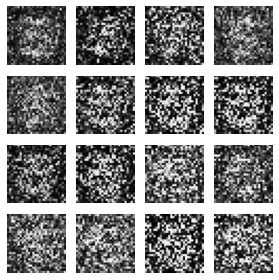

Epoch: 1800, [Discriminator :: Loss: 0.0008785362], [ Generator :: Loss: 13.916722]


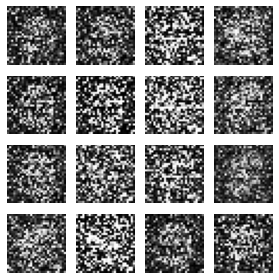

Epoch: 1900, [Discriminator :: Loss: 0.00037018], [ Generator :: Loss: 12.437017]


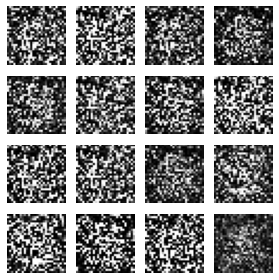

Epoch: 2000, [Discriminator :: Loss: 0.0045486502], [ Generator :: Loss: 12.074237]


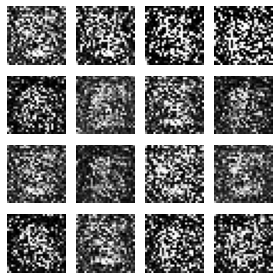

Epoch: 2100, [Discriminator :: Loss: 0.01072671], [ Generator :: Loss: 9.952803]


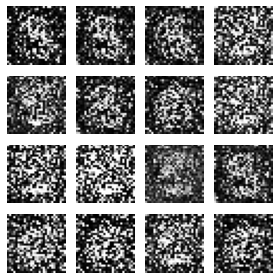

Epoch: 2200, [Discriminator :: Loss: 0.0007407258], [ Generator :: Loss: 11.263838]


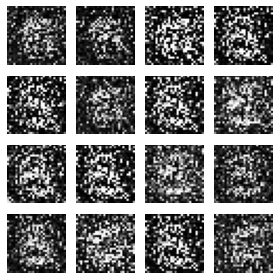

Epoch: 2300, [Discriminator :: Loss: 0.12697197], [ Generator :: Loss: 13.951994]


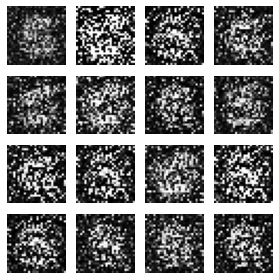

Epoch: 2400, [Discriminator :: Loss: 0.0022672818], [ Generator :: Loss: 9.361773]


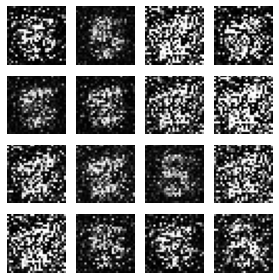

Epoch: 2500, [Discriminator :: Loss: 0.013615321], [ Generator :: Loss: 13.488734]


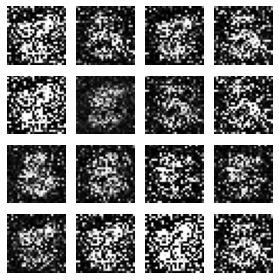

Epoch: 2600, [Discriminator :: Loss: 0.06654165], [ Generator :: Loss: 11.279892]


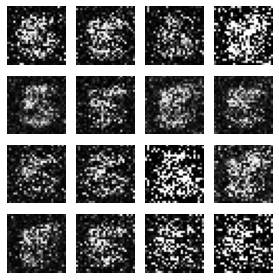

Epoch: 2700, [Discriminator :: Loss: 0.16667274], [ Generator :: Loss: 10.424945]


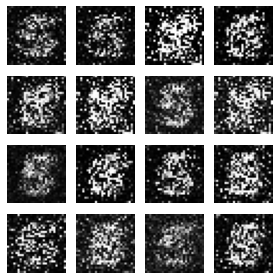

Epoch: 2800, [Discriminator :: Loss: 0.03679437], [ Generator :: Loss: 8.196057]


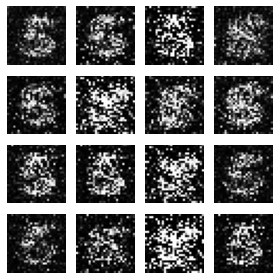

Epoch: 2900, [Discriminator :: Loss: 0.0018857577], [ Generator :: Loss: 8.043722]


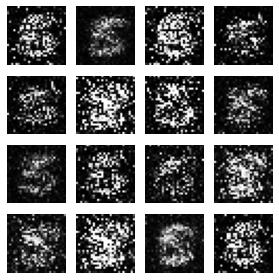

Epoch: 3000, [Discriminator :: Loss: 0.014299387], [ Generator :: Loss: 11.06266]


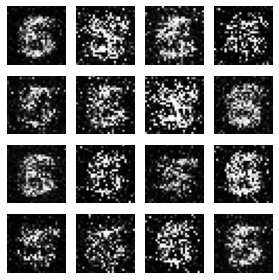

Epoch: 3100, [Discriminator :: Loss: 0.113226034], [ Generator :: Loss: 9.656493]


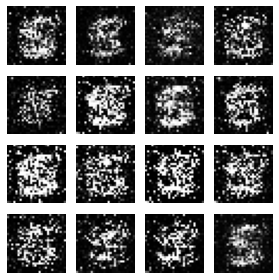

Epoch: 3200, [Discriminator :: Loss: 0.010607868], [ Generator :: Loss: 8.912607]


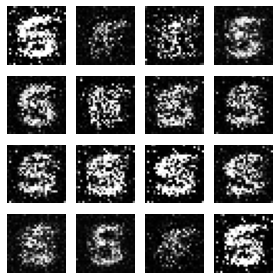

Epoch: 3300, [Discriminator :: Loss: 0.020456638], [ Generator :: Loss: 9.841435]


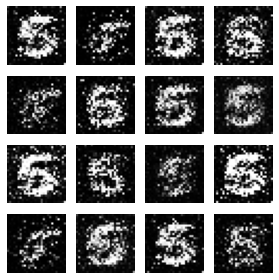

Epoch: 3400, [Discriminator :: Loss: 0.009035334], [ Generator :: Loss: 10.046643]


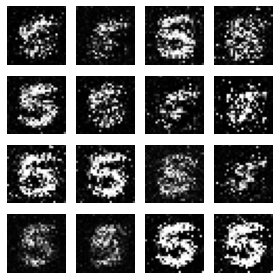

Epoch: 3500, [Discriminator :: Loss: 0.18124603], [ Generator :: Loss: 11.326952]


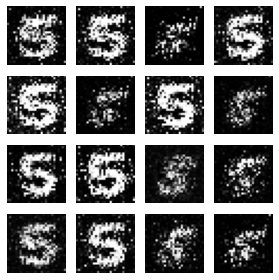

Epoch: 3600, [Discriminator :: Loss: 0.03625247], [ Generator :: Loss: 10.234775]


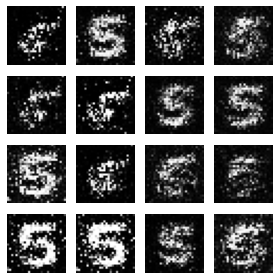

Epoch: 3700, [Discriminator :: Loss: 0.037892707], [ Generator :: Loss: 9.003572]


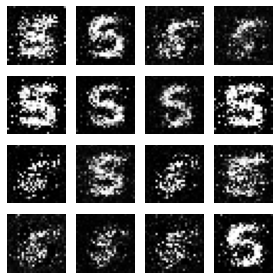

Epoch: 3800, [Discriminator :: Loss: 0.093527704], [ Generator :: Loss: 6.3627014]


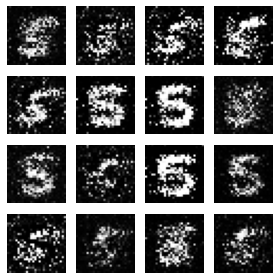

Epoch: 3900, [Discriminator :: Loss: 0.05514136], [ Generator :: Loss: 10.247461]


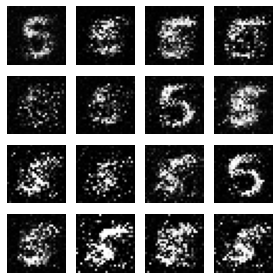

Epoch: 4000, [Discriminator :: Loss: 0.03203354], [ Generator :: Loss: 4.4014506]


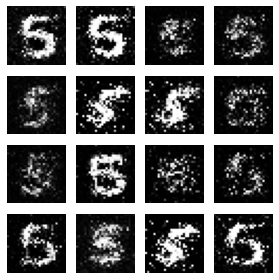

Epoch: 4100, [Discriminator :: Loss: 0.105541565], [ Generator :: Loss: 9.397033]


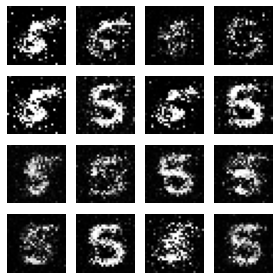

Epoch: 4200, [Discriminator :: Loss: 0.4567523], [ Generator :: Loss: 5.5154295]


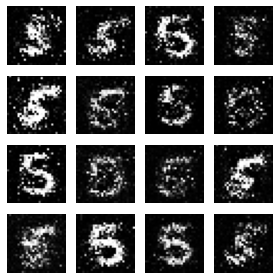

Epoch: 4300, [Discriminator :: Loss: 0.082929164], [ Generator :: Loss: 5.8955817]


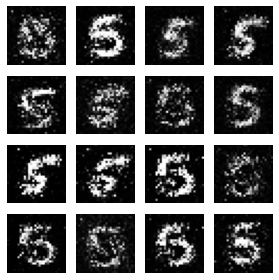

Epoch: 4400, [Discriminator :: Loss: 0.018765062], [ Generator :: Loss: 5.685912]


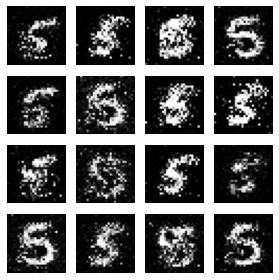

Epoch: 4500, [Discriminator :: Loss: 0.0512493], [ Generator :: Loss: 9.655431]


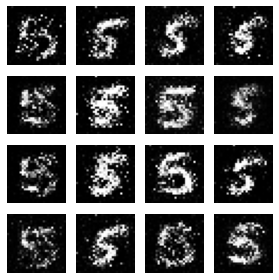

Epoch: 4600, [Discriminator :: Loss: 0.2736842], [ Generator :: Loss: 6.373498]


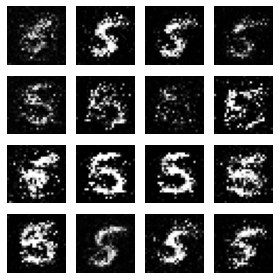

Epoch: 4700, [Discriminator :: Loss: 0.13686603], [ Generator :: Loss: 3.5285983]


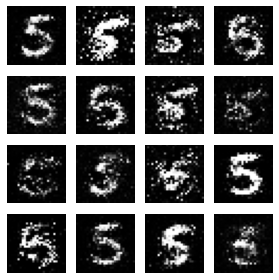

Epoch: 4800, [Discriminator :: Loss: 0.107918195], [ Generator :: Loss: 4.060739]


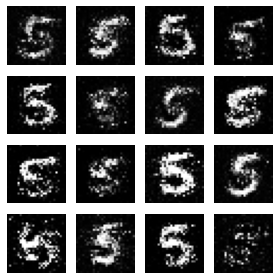

Epoch: 4900, [Discriminator :: Loss: 0.08591804], [ Generator :: Loss: 5.7885466]


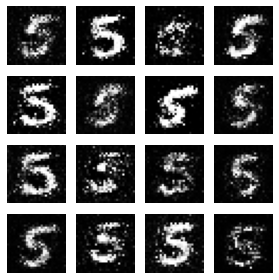

In [ ]:
trainer.train()

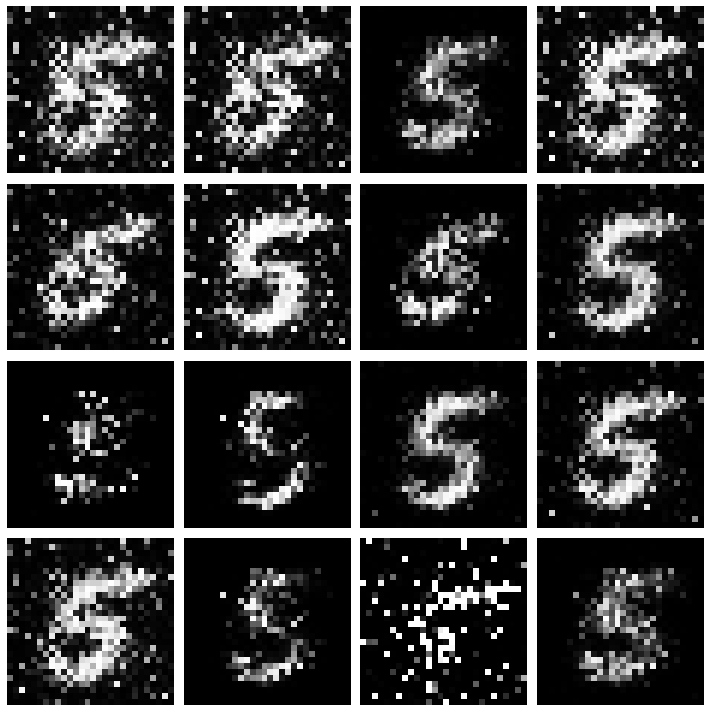

In [ ]:
noise = trainer.sample_latent_space(16)
images = trainer.generator.Generator.predict(noise)

plt.figure(figsize=(10,10))
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [28,28])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()
        